# Inteligencia Artificial 2
## P1 Project: Implement a Recommender system using a bipartite network projection
### Autores: Miguel Brito, Diana Cuenca, José Escudero, Danny Huacon, Steveen Terán

En el presente informe, se abordará la implementación de un sistema de recomendación con el uso de una red bipartita. Esta es una técnica que permite analizar relaciones complejas entre dos conjuntos de elementos. Por ello, se analizará y proyectara una red de productos en funcion de las recomendaciones emitidas por los usuarios. Lo que permitirá identificar patrones y conexiones significativas entre los productos, lo que facilitará la generación de recomendaciones personalizadas.

### imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
import pickle
import math



### Load five stars review data

Se lee el archivo de los datos y se carga en un dataframe, asi también se especifica los nombres de las columnas, y se muestran las priumeras 5 filas. 

_Cabe aclarar que se eliminó la columna timestamp con el fin de reducir la dimensionalidad de los datos, además que no se vió la relevancia para el objetivo y posterior análisis de este informe._

In [2]:
electronics_data = pd.read_csv("./ratings_electronics.csv", names=['userId', 'productId', 'rating', 'timestamp'])
# Eliminar la columna 'timestamp' de los datos
electronics_data.drop(['timestamp'], axis=1,inplace=True)
five_star_reviews = electronics_data[electronics_data['rating'] == 5.0]
five_star_reviews.head()


,userId,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
5,A1QGNMC6O1VW39,0511189877,5.0
7,A2TY0BTJOTENPG,0511189877,5.0
8,A34ATBPOK6HCHY,0511189877,5.0


### Create bipartite graph

In [3]:
user_ids = set(five_star_reviews['userId'])
product_ids = set(five_star_reviews['productId'])

# Crear el grafo bipartito
B = nx.from_pandas_edgelist(five_star_reviews, 'userId', 'productId', edge_attr=None, create_using=None)

# Assign label to nodes
for node in B.nodes():
    if node in user_ids:
        B.nodes[node]['bipartite'] = 'users'
    else:
        B.nodes[node]['bipartite'] = 'products'


### Create product projection

On my machine (M1 Pro, 32GB) it takes around 5 mins to run.\
If you want to save your time then just read the projection from the pickle file.

In [4]:
import os
file_exists = os.path.isfile('product_projection.pickle')
if file_exists:
  with open('product_projection.pickle', 'rb') as handle:
    product_projection = pickle.load(handle)
else:
  product_projection = nx.bipartite.weighted_projected_graph(B, product_ids)
  with open('product_projection.pickle', 'wb') as handle:
    pickle.dump(product_projection, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Relevant functions for obtaining neighbor weights

In [5]:
def get_sorted_neighbors_by_weight(graph, node):
    neighbors = graph.neighbors(node)
    neighbors_with_weight = [(neighbor, graph[node][neighbor]['weight']) for neighbor in neighbors]
    neighbors_with_weight = sorted(neighbors_with_weight, key=lambda x: x[1], reverse=True)
    return neighbors_with_weight

def get_top_neighbors(graph, node, limit=10):
    neighbors_with_weight = get_sorted_neighbors_by_weight(graph, node)
    return dict(neighbors_with_weight[:limit])


### Test with the products drawn on the homework description

In [6]:
print("B00ELRTZ5Y")
neighbor_weights = get_top_neighbors(product_projection, "B00ELRTZ5Y", 5)
for neighbor, weight in neighbor_weights.items():
    print(f"Neighbor: {neighbor}, Weight: {weight}")
print("==========================================")
print("B004SD22PQ")
neighbor_weights = get_top_neighbors(product_projection, "B004SD22PQ", 5)
for neighbor, weight in neighbor_weights.items():
    print(f"Neighbor: {neighbor}, Weight: {weight}")
print("==========================================")
print("B005Y586QQ")
neighbor_weights = get_top_neighbors(product_projection, "B005Y586QQ", 5)
for neighbor, weight in neighbor_weights.items():
    print(f"Neighbor: {neighbor}, Weight: {weight}")





B00ELRTZ5Y
Neighbor: B0088LYCZC, Weight: 2
Neighbor: B000EP4TWQ, Weight: 1
Neighbor: B003YK4798, Weight: 1
Neighbor: B006YLYYZ6, Weight: 1
Neighbor: B00B7YBE9E, Weight: 1
B004SD22PQ
Neighbor: B005DOK8NW, Weight: 30
Neighbor: B007R5YDYA, Weight: 7
Neighbor: B004JWA70I, Weight: 4
Neighbor: B003ELYQGG, Weight: 4
Neighbor: B0074BW614, Weight: 4
B005Y586QQ
Neighbor: B007P4VOWC, Weight: 7
Neighbor: B005N130Y4, Weight: 5
Neighbor: B007TYUTY2, Weight: 4
Neighbor: B008MPVUK4, Weight: 3
Neighbor: B007M506WS, Weight: 3


### Drawing functions

In [7]:
def obtain_positions(vector):
    (x, y) = vector
    magnitude = math.sqrt(x**2 + y**2)
    unit_vector = (x / magnitude, y / magnitude)
    desired_magnitude = 0.5 * magnitude
    return (unit_vector[0] * desired_magnitude, unit_vector[1] * desired_magnitude)

def get_edge_color(edge, top_neighbors):
    return 'red' if edge[0] in top_neighbors or edge[1] in top_neighbors else 'black'


def draw_recommendation_graph(selected_node, limit, highlight_limit):
    sorted_neighbors = get_sorted_neighbors_by_weight(product_projection, selected_node)
    top_neighbors = get_top_neighbors(product_projection, selected_node, highlight_limit).keys()

    # Extract neighbors and widths from sorted_neighbors
    neighbors, widths = map(list, zip(*sorted_neighbors[:limit]))

    # Create subgraph nodes including the selected node and its neighbors
    subgraph_nodes = [selected_node, *neighbors]

    # Get positions for the graph visualization
    star_graph = nx.star_graph(subgraph_nodes)
    pos = nx.circular_layout(star_graph)
    pos[selected_node] = [0.00001, 0.00001]
    new_positions = {node: obtain_positions(vector) for node, vector in pos.items()}

    # Set node colors, edge colors, and edge labels
    node_colors = ['green' if node == selected_node else 'skyblue' for node in star_graph.nodes()]
    edge_colors = [get_edge_color(edge, top_neighbors) for edge in star_graph.edges()]
    edge_labels = {pair[0]: pair[1] for pair in sorted_neighbors[:limit]}

    # Draw the graph
    nx.draw(star_graph, pos=pos, with_labels=True, node_color=node_colors, width=widths, node_size=1000, edge_color=edge_colors)
    nx.draw_networkx_labels(star_graph, new_positions, labels=edge_labels, bbox=dict(facecolor="white"))





### Draw the 3 examples

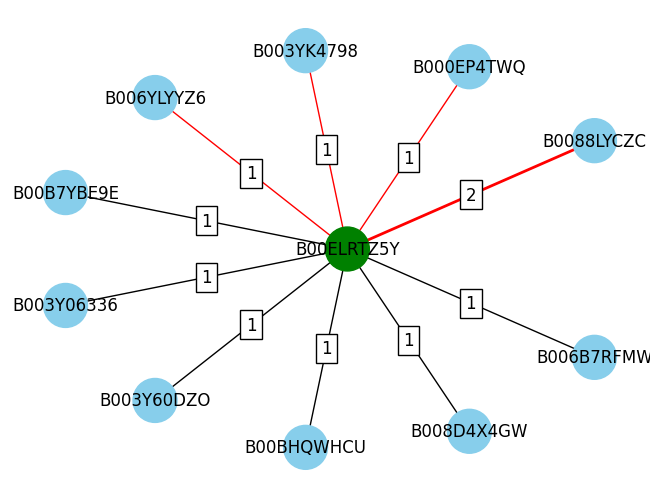

In [8]:
draw_recommendation_graph("B00ELRTZ5Y", 10, 4)


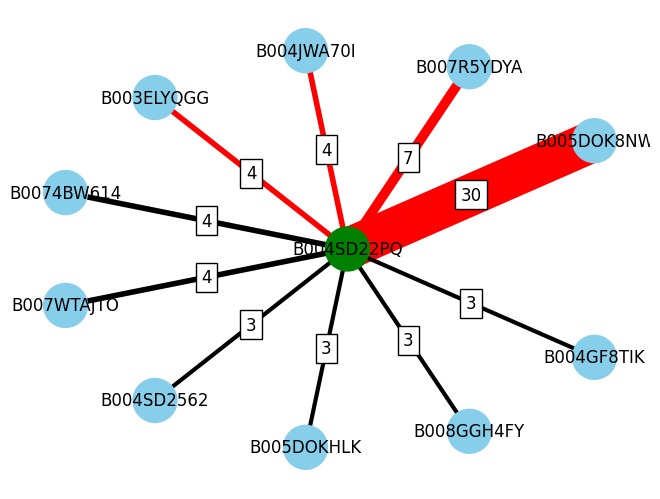

In [9]:
draw_recommendation_graph("B004SD22PQ", 10, 4)


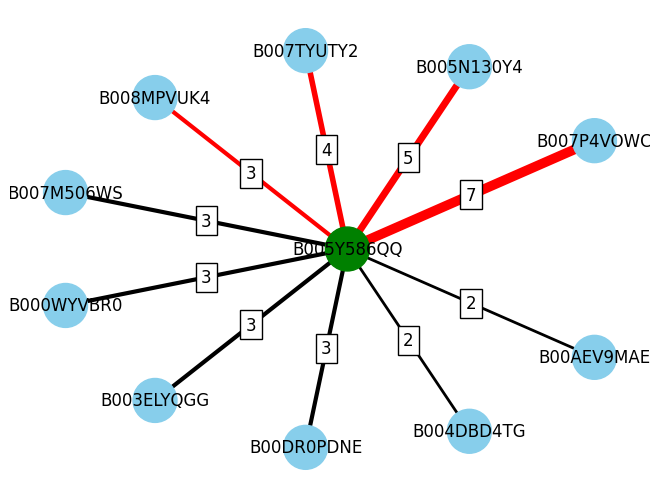

In [10]:
draw_recommendation_graph("B005Y586QQ", 10, 4)


### Dropdown menu

Dropdown(description='Product ID:', options=('B000VEAZ8M', 'B005MJD2IG', 'B002P4YRBW', 'B004VO4K6Q', 'B0081TWA…

Dropdown(description='N recommendations:', index=4, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=5)

Button(description='Consultar', icon='check', style=ButtonStyle(), tooltip='Click me')

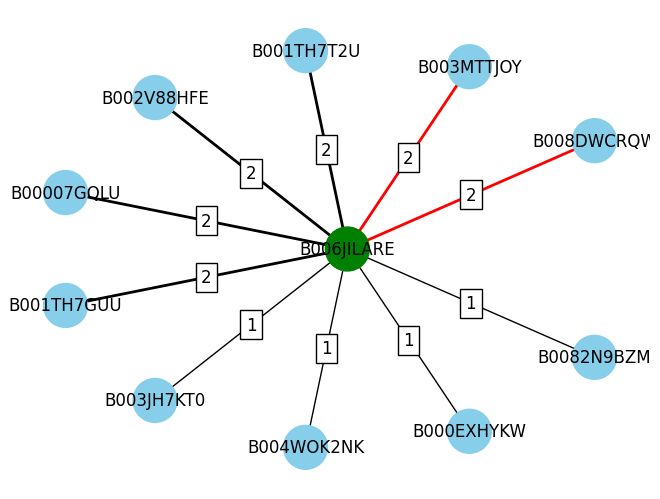

In [19]:
import ipywidgets as widgets
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def query(btn):
    # clear previous graph
    plt.clf()
    product_id = product_id_widget.value
    n_limit = n_limit_widget.value
    draw_recommendation_graph(product_id, 10, n_limit)

product_nodes = list(product_ids)[:1000]


product_id_widget = widgets.Dropdown(
    options=product_nodes,
    value=product_nodes[0],
    description='Product ID:',
    disabled=False,
)
n_limit_widget = widgets.Dropdown(
    options=list(range(1,11)),
    value=5,
    description='N recommendations:',
    disabled=False,
)

button = widgets.Button(
    description='Consultar',
    disabled=False,
    button_style='',
    tooltip='Click me',
    icon='check'
)

button.on_click(query)

product_id_widget
n_limit_widget
button


### Conlusiones

- A través del uso de una red bipartita se puede demostrar que resulta se ejecuta para modelar las interacciones, en el caso del presente informe, entre usuarios y productos. Lo cual permite aumentar la calidad del sistema de recomendación a través del uso de técnicas como la proyección ponderada y considerar umbrales o grados de interación entre los productos y usuarios.

- Así también, es importante destacar la optimizacón del modelo a través de una poda selectiva que demostró ser una estrategia correcta para mejorar la eficienica computacional sin compromenter la integridad de los datos.